# Distributed Columnar HEP analysis using coffea + dask

### Warning: In this talk we will assume some familiarity with the uproot+awkward way of dealing with data.

### Columnar analysis and coffea
What is `coffea`? Coffea is a set of basic tools and wrappers for enabling not-too-alien syntax when running columnar Collider HEP analysis.

What is columnar analysis:

* Event loop analysis:
    - Load relevant values for a specific event into local variables
    - Evaluate several expressions
    - Store derived values
    - Repeat (explicit outer loop)
* Columnar analysis:
    - Load relevant values for many events into contiguous arrays
    - Evaluate several array programming expressions
        - Implicit inner loops
        - Plan analysis by composing data manipulations
    - Store derived values

<img src="img/columnar.png" width="400" style="margin-right: 20px;"><img src="img/columnar-code.png" width="400">

### Dask

Dask provides an interface for specifying/locating input data and then describing manipulations on that data are organized into a task graph. This task graph can then be executed on local compute or on a cluster. Dask Array and Dask Dataframe deal well with rectangular data. They provide a scalable interface to describe manipulations of data that may not fit into
system memory by mapping transformations onto partitions of the data that fit in memory.

<img src="https://docs.dask.org/en/stable/_images/dask-overview.svg" width="400" style="margin-right: 20px;"><img src="https://docs.dask.org/en/latest/_images/dask-array.svg" width="400">

But in physics we're dealing with [jagged or ragged arrays](https://en.wikipedia.org/wiki/Jagged_array). A ragged array is something like this:

```
[[1, 2, 3],
 [4],
 [],
 [5, 6]]
---------------------
type: 4 * var * int64
```

In the pythonic HEP ecosystem, we deal with those kinds of arrays using [awkward](https://github.com/scikit-hep/awkward). Awkward Arrays are general tree-like data structures, like JSON, but contiguous in memory and operated upon with compiled, vectorized code like NumPy. For more information, please visit the [awkward array docs](https://awkward-array.org/doc/main/index.html) and/or see [previous talks from Jim Pivarski](https://github.com/jpivarski-talks/).

### How jagged arrays and histogramming are integrated with dask: awkward array 2.0, dask_awkward, dask_histogram, and coffea

<img src="img/coffea-upgrade.png" width="600">

Awkward array 2.0 features an improved and streamlined backend with. The backend is using only C and python without any C++ metadata handling. `ak.virtual` delayed computations are replaced by [dask-awkward](https://github.com/dask-contrib/dask-awkward).

`dask_awkward` and `dask_histogram` bring delayed, distributed computation to `awkward array 2.0` based analyses and libraries. [Uproot](https://github.com/scikit-hep/uproot5) now provides lazy reading of data via [uproot.dask](https://uproot.readthedocs.io/en/latest/uproot._dask.dask.html).

#### Our partitions are split on the event axis since each event is independent and we never run computations that combine more than 1 events.

All that provides access to dask at all layers of analysis which yields improved parallelism and better factorization away from compute infrastructure.
Coffea, and `NanoEvents` in particular which was almost entirely based on `ak.virtual`, now leverage all this infrastructure.

Please see [Lindsey's CHEP 2023 talk](https://indico.jlab.org/event/459/contributions/11533/attachments/9496/13762/CoffeaCHEP_LindseyGray_09052023.pdf) for more info on those upgrades.

Let's start showcasing how to use all that.

In [1]:
import hist
import dask
import awkward as ak
import hist.dask as hda
import dask_awkward as dak

from coffea import processor
from coffea.nanoevents import NanoEventsFactory, BaseSchema
from coffea.nanoevents.methods import candidate
from coffea.dataset_tools import apply_to_fileset, preprocess
from distributed import Client
from matplotlib import pyplot as plt

/Users/iason/fun/pyhep2024-coffea-dask/.venv/lib/python3.11/site-packages/coffea/nanoevents/methods/candidate.py:11: FutureWarning: In version 2024.7.0 (target date: 2024-06-30 11:59:59-05:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


We read our data with `NanoEventsFactory`

In [2]:
events = NanoEventsFactory.from_root({"data/DYto2E.root": "Events"}).events()
events

dask.awkward<from-uproot, npartitions=1>

Events is a lazy dask-awkward collection. In order to actually compute something, you'd have to call `.compute()` on some collection. For example:

In [3]:
events.Electron.pt.compute()

<Array [[43.2, 41.4], [...], ..., [48.8, 36.5]] type='1000 * var * float32[...'>

Let's do a Tag & Probe analysis to measure some ID efficiency to showcase the functionality of coffea. Tag & Probe is used as a technique because we cannot trust our simulation to perfectly describe the detector response so we need to measure the efficiency in data, categorizing signal and background by inference. How do we do this without selection bias? Thanks to the Z boson, we have a solution: tag one electron in an event that passes some high quality requirement, then look for a "probe" electron such that the invariant mass of the di-electron pair matches that of the Z boson. If we count the number of probes falling in some mass window that pass and fail our ID, we can infer the true electron tagging efficiency in data, despite not knowing the ground truth for each electron. This can also be used for photons instead of electrons as electrons will interact like photons with our calorimeter.

In [4]:
def trigger_match(leptons, trigobjs, pdgid, pt, filterbit):
    """
    Matches a lepton with an online trigger object using dR < 0.1
    The filterbit corresponds to the trigger we want our lepton to have fired
    """
    pass_pt = trigobjs.pt > pt
    pass_id = abs(trigobjs.id) == pdgid
    pass_filterbit = (trigobjs.filterBits & (0x1 << filterbit)) != 0
    trigger_cands = trigobjs[pass_pt & pass_id & pass_filterbit]
    delta_r = leptons.metric_table(trigger_cands)
    pass_delta_r = delta_r < 0.1
    n_of_trigger_matches = dak.sum(pass_delta_r, axis=2)
    trig_matched_locs = n_of_trigger_matches >= 1

    return trig_matched_locs

In [5]:
# select events where Ele30_WPTight_Gsf (an isolated electron with a transverse momentum 𝑝_T > 30 GeV)
good_events = events[events.HLT.Ele30_WPTight_Gsf]

# form all possible diphoton pairs and removing pairs of photons with themselves
ij = dak.argcartesian([good_events.Photon, good_events.Photon])
is_not_diag = ij["0"] != ij["1"]
i, j = dak.unzip(ij[is_not_diag])
zcands = dak.zip({"tag": good_events.Photon[i], "probe": good_events.Photon[j]})

# request tags to have tight cutbased id and mask zcands
pass_tight_id_tags = zcands.tag.cutBased >= 3
zcands = zcands[pass_tight_id_tags]

# do not allow tags to be in the ECAL transition region between barrel and endcap
pass_eta_ebeegap_tags = (abs(zcands.tag.eta) < 1.4442) | (abs(zcands.tag.eta) > 1.566)
zcands = zcands[pass_eta_ebeegap_tags]

In [6]:
trigobjs = good_events.TrigObj

# put pt and eta cuts on the tags and probes
pt_cond_tags = zcands.tag.pt > 35
pt_cond_probes = zcands.probe.pt > 5
eta_cond_tags = abs(zcands.tag.eta) < 2.17
eta_cond_probes = abs(zcands.probe.eta) < 2.5

# request the tag to "be an electron and not a photon" by requiring a pixel track and an associated electron index.
has_matched_electron_tags = (zcands.tag.electronIdx != -1) & (zcands.tag.pixelSeed)

# require tags to have fired Ele30_WPTight_Gsf
# pdgid = 11 for electron, pt = 30 threshold and filterbit = 1 for this trigger
trig_matched_tag = trigger_match(zcands.tag.matched_electron, trigobjs, 11, 30, 1)

# mask Z-candidates with all previous requirements and cuts
zcands = zcands[
    has_matched_electron_tags
    & trig_matched_tag
    & pt_cond_tags
    & pt_cond_probes
    & eta_cond_tags
    & eta_cond_probes
]

# drop every event that doesn't have a good tag
events_with_tags = ak.num(zcands.tag, axis=1) >= 1
zcands = zcands[events_with_tags]
trigobjs = trigobjs[events_with_tags]
good_events = good_events[events_with_tags]

In [7]:
# only allow invariant mass of tag-probe pairs between 50 and 130 GeV
mass = (zcands.tag + zcands.probe).mass
in_mass_window = (mass > 50) & (mass < 130)
zcands = zcands[in_mass_window]

# we will be checking the efficiency of Tight Cutbased ID (that is 3 in NanoAOD for photons)
# therefore a passing probe is a probe that passed this ID requirement
is_passing_probe = zcands.probe.cutBased >= 3
passing_pairs = zcands[is_passing_probe]
failing_pairs = zcands[~is_passing_probe]

# calculate the invariant mass of the passing/failing tag-probe pairs and flatten
passing_pairs_mass = dak.flatten((passing_pairs.tag + passing_pairs.probe).mass)
failing_pairs_mass = dak.flatten((failing_pairs.tag + failing_pairs.probe).mass)

Up until this point, nothing has been computed. What has happened is that the operations have only been run on typetracer arrays and a task graph which you can inspect has been created.

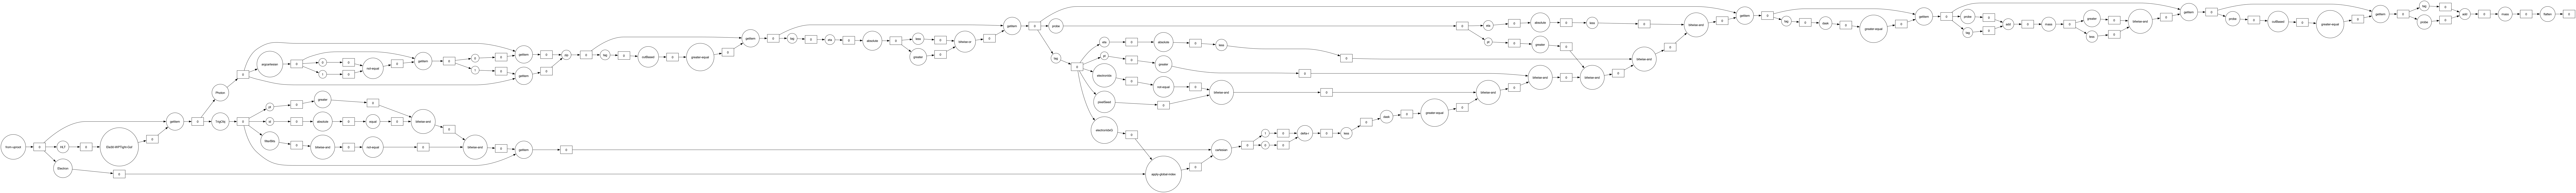

In [8]:
dask.visualize(passing_pairs_mass, optimize_graph=False, rankdir="LR")

Actually this isn't the spot where we have to evaluate this task graph. We can do lazy histograms as well thanks to `dask-histogram` and its minimal interface with `hist`.

In [9]:
# fill histograms with the flattened invariant mass arrays
hpass = hda.Hist(hist.axis.Regular(80, 50, 130, label="mll"))
hfail = hda.Hist(hist.axis.Regular(80, 50, 130, label="mll"))

hpass.fill(passing_pairs_mass)
hfail.fill(failing_pairs_mass)
print(hpass.staged_fills())
print(hfail.staged_fills())
hpass

True
True


Hist(Regular(80, 50, 130, label='mll'), storage=Double()) # (has staged fills)

Now the histogramming has become part of the task-graph as well.

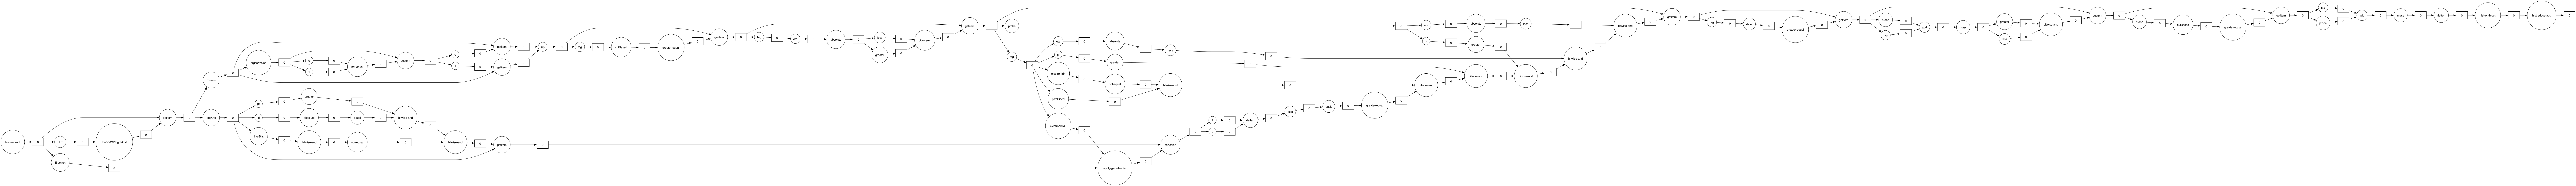

In [10]:
dask.visualize(hpass, optimize_graph=False, rankdir="LR")

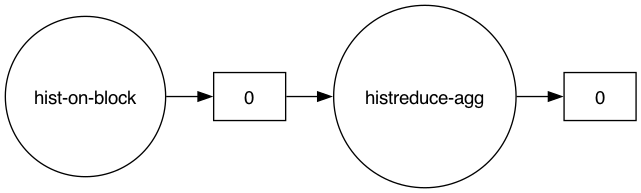

In [11]:
dask.visualize(hpass, optimize_graph=True, rankdir="LR")

What one can also do is view the necessary columns that a task graphs need to read from the files in order to compute them.

In [12]:
dak.necessary_columns(hpass, hfail)

{'from-uproot-96a08f8ecd8d4ce2ed61675a7d50afa1': frozenset({'Electron_eta',
            'Electron_phi',
            'HLT_Ele30_WPTight_Gsf',
            'Photon_cutBased',
            'Photon_electronIdx',
            'Photon_eta',
            'Photon_phi',
            'Photon_pixelSeed',
            'Photon_pt',
            'TrigObj_eta',
            'TrigObj_filterBits',
            'TrigObj_id',
            'TrigObj_phi',
            'TrigObj_pt',
            'nElectron',
            'nPhoton',
            'nTrigObj'})}

Only the branches specified above will actually be read from the file. This minimizes data reading. For more info you can read the [dask-awkward docs](https://dask-awkward.readthedocs.io/en/stable/more/optimization.html).

Let's now plot the invariant mass spectra of the passing and failing probes. We first gotta call `.compute()` on our histograms and then plot them.

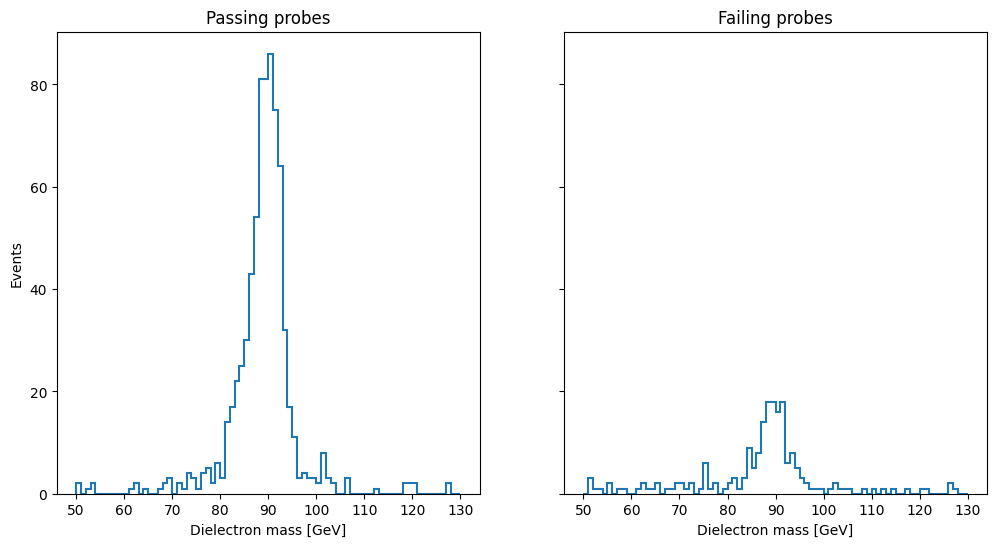

In [13]:
fig, (axp, axf) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))

hpass.compute().plot(ax=axp, yerr=False)
axp.set_title("Passing probes")
axp.set_ylabel("Events")
axp.set_xlabel("Dielectron mass [GeV]")

hfail.compute().plot(ax=axf, yerr=False)
axf.set_title("Failing probes")
axf.set_xlabel("Dielectron mass [GeV]")

plt.show()

And we got our histograms of the passing and failing probes. They don't look great because we started only from 1000 events.
Here one would fit a Signal + Background model to the passing and failing probes to extract the actual number of passing and failing probes coming from a Z boson since there is background in the invariant mass spectra. Assuming that from the fit the passing and failing probe yields from the Z are $n_{pass}$ and $n_{fail}$ respectively, then the efficiency is

$$
\epsilon = \frac{n_{pass}}{n_{pass} + n_{fail}}.
$$

Up until this point, we've been doing a lot of things more manually. We manually read our events, ran the analysis code and called `.compute()` on each of the collections we wanted to actually evaluate in the end. We've been very explicit for demonstration purposes but this isn't the most efficient way of dealing with things.
First of all, you'd normally want to use `dask.compute(**things)` so that dask optimizes and fuses the separate task graphs of "things" as much as it can. Secondly, we been computing things locally using local threads in our previous example. Normally one would use a local or distributed dask [Cluster](https://docs.dask.org/en/stable/deploying.html) and [Client](https://distributed.dask.org/en/latest/client.html). Let's do that while also combining it with more of coffea's advanced features in the next example.

We start be defining our fileset and using `coffea`'s `preprocess` function to preprocess our fileset.
This checks whether the files are accessible, reads things like the number of events contained within the files and splits them into partitions of ~100000 events each.
It will return a "runnable" fileset and an "updated" fileset with the partitions specified.

In [14]:
# fileset = {
#     "DoubleMuon": {
#         "files": {
#             "root://eospublic.cern.ch//eos/root-eos/cms_opendata_2012_nanoaod/Run2012B_DoubleMuParked.root": "Events",
#             "root://eospublic.cern.ch//eos/root-eos/cms_opendata_2012_nanoaod/Run2012C_DoubleMuParked.root": "Events",
#             "root://eospublic.cern.ch//eos/root-eos/cms_opendata_2012_nanoaod/not_a_DoubleMu_file.root": "Events",
#         }
#     },
#     "ZZto4mu": {
#         "files": {
#             "root://eospublic.cern.ch//eos/root-eos/cms_opendata_2012_nanoaod/ZZTo4mu.root": "Events",
#             "root://eospublic.cern.ch//eos/root-eos/cms_opendata_2012_nanoaod/not_a_ZZTo4mu_file.root": "Events",
#         }
#     },
# }

fileset = {
    "ZZto4mu": {
        "files": {
            "data/ZZTo4mu.root": "Events",
            "data/not_a_ZZTo4mu_file.root": "Events",
        }
    },
    "SMHiggsToZZTo4L": {
        "files": {
            "data/SMHiggsToZZTo4L.root": "Events",
            "data/not_a_SMHiggsToZZTo4L_file.root": "Events",
        }
    },
}


dataset_runnable, dataset_updated = preprocess(
    fileset,
    step_size=100_000,
    skip_bad_files=True,
)

In [15]:
dataset_runnable

{'ZZto4mu': {'files': {'data/ZZTo4mu.root': {'object_path': 'Events',
    'steps': [[0, 99938],
     [99938, 199876],
     [199876, 299814],
     [299814, 399752],
     [399752, 499690],
     [499690, 599628],
     [599628, 699566],
     [699566, 799504],
     [799504, 899442],
     [899442, 999380],
     [999380, 1099318],
     [1099318, 1199256],
     [1199256, 1299194],
     [1299194, 1399132],
     [1399132, 1499064]],
    'num_entries': 1499064,
    'uuid': 'a7a145f4-bebc-11eb-a189-c4650d81beef'}},
  'form': None,
  'metadata': None},
 'SMHiggsToZZTo4L': {'files': {'data/SMHiggsToZZTo4L.root': {'object_path': 'Events',
    'steps': [[0, 99991], [99991, 199982], [199982, 299973]],
    'num_entries': 299973,
    'uuid': '9f98a208-bebc-11eb-9992-c4650d81beef'}},
  'form': None,
  'metadata': None}}

A coffea concept that is actually not required to be used anymore is the [coffea processor](https://coffeateam.github.io/coffea/concepts.html#coffea-processor). This is very useful for organization but one could also use any function `function(events)` that defines their analysis. We need this signature because this is what coffea requires to apply the analysis to the whole fileset. If a processor is used, then the processor's `.process(events)` method will be the one applied to the fileset.

Let's write up a fancy dimuon processor. The following processor showcases a lot of tricky things for beginners, like using awkward's array builder, jit compilation, using `dak.map_partitions` to apply functions that are not written in plain awkward to partitions and defining a custom vector collection.
Notice that we use `ak.some_function` instead of `dak.some_function` as there is an automatic dispatch from awkward -> dask-awkward when a function is called on a dask-awkward collection.
We will use `BaseSchema` to showcase the vector building but we could have used `NanoAODSchema` and that wouldn't be required.

In [16]:
import numba


@numba.njit
def find_4lep_kernel(events_leptons, builder):
    """Search for valid 4-lepton combinations from an array of events * leptons {charge, ...}

    A valid candidate has two pairs of leptons that each have balanced charge
    Outputs an array of events * candidates {indices 0..3} corresponding to all valid
    permutations of all valid combinations of unique leptons in each event
    (omitting permutations of the pairs)
    """
    for leptons in events_leptons:
        builder.begin_list()
        nlep = len(leptons)
        for i0 in range(nlep):
            for i1 in range(i0 + 1, nlep):
                if leptons[i0].charge + leptons[i1].charge != 0:
                    continue
                for i2 in range(nlep):
                    for i3 in range(i2 + 1, nlep):
                        if len({i0, i1, i2, i3}) < 4:
                            continue
                        if leptons[i2].charge + leptons[i3].charge != 0:
                            continue
                        builder.begin_tuple(4)
                        builder.index(0).integer(i0)
                        builder.index(1).integer(i1)
                        builder.index(2).integer(i2)
                        builder.index(3).integer(i3)
                        builder.end_tuple()
        builder.end_list()

    return builder


def find_4lep(events_leptons):
    if ak.backend(events_leptons) == "typetracer":
        # here we fake the output of find_4lep_kernel since
        # operating on length-zero data returns the wrong layout!
        ak.typetracer.touch_data(
            events_leptons.charge
        )  # force touching of the necessary data
        # Use x = ak.typetracer.length_zero_if_typetracer(events_leptons.charge) or x = ak.typetracer.length_one_if_typetracer(events_leptons.charge)
        # if you want a a length-zero/one NumPy-backed array to be returned for your computations
        return ak.Array(
            ak.Array([[(0, 0, 0, 0)]]).layout.to_typetracer(forget_length=True)
        )
    return find_4lep_kernel(events_leptons, ak.ArrayBuilder()).snapshot()


class FancyDimuonProcessor(processor.ProcessorABC):
    # The processor can also have an __init__ method

    def process(self, events):
        dataset_axis = hist.axis.StrCategory(
            [], growth=True, name="dataset", label="Primary dataset"
        )
        mass_axis = hist.axis.Regular(
            300, 0, 300, name="mass", label=r"$m_{\mu\mu}$ [GeV]"
        )
        pt_axis = hist.axis.Regular(300, 0, 300, name="pt", label=r"$p_{T,\mu}$ [GeV]")

        h_nMuons = hda.Hist(
            dataset_axis,
            hda.hist.hist.axis.IntCategory(
                range(6), name="nMuons", label="Number of good muons"
            ),
            storage="weight",
            label="Counts",
        )
        h_m4mu = hda.hist.Hist(
            dataset_axis, mass_axis, storage="weight", label="Counts"
        )
        h_mZ1 = hda.hist.Hist(dataset_axis, mass_axis, storage="weight", label="Counts")
        h_mZ2 = hda.hist.Hist(dataset_axis, mass_axis, storage="weight", label="Counts")
        h_ptZ1mu1 = hda.hist.Hist(
            dataset_axis, pt_axis, storage="weight", label="Counts"
        )
        h_ptZ1mu2 = hda.hist.Hist(
            dataset_axis, pt_axis, storage="weight", label="Counts"
        )

        cutflow = dict()

        dataset = events.metadata["dataset"]
        muons = ak.zip(
            {
                "pt": events.Muon_pt,
                "eta": events.Muon_eta,
                "phi": events.Muon_phi,
                "mass": events.Muon_mass,
                "charge": events.Muon_charge,
                "isolation": events.Muon_pfRelIso03_all,
            },
            with_name="PtEtaPhiMCandidate",
            behavior=candidate.behavior,
        )

        # make sure they are sorted by transverse momentum
        muons = muons[ak.argsort(muons.pt, axis=1)]

        cutflow["all events"] = ak.num(muons, axis=0)

        # impose some quality and minimum pt cuts on the muons
        muons = muons[(muons.pt > 5) & (muons.isolation < 0.2)]
        cutflow["at least 4 good muons"] = ak.sum(ak.num(muons) >= 4)
        h_nMuons.fill(dataset=dataset, nMuons=ak.num(muons))

        # reduce first axis: skip events without enough muons
        muons = muons[ak.num(muons) >= 4]

        # find all candidates with helper function
        fourmuon = dak.map_partitions(find_4lep, muons)
        fourmuon = [muons[fourmuon[idx]] for idx in "0123"]

        fourmuon = ak.zip(
            {
                "z1": ak.zip(
                    {
                        "lep1": fourmuon[0],
                        "lep2": fourmuon[1],
                        "p4": fourmuon[0] + fourmuon[1],
                    }
                ),
                "z2": ak.zip(
                    {
                        "lep1": fourmuon[2],
                        "lep2": fourmuon[3],
                        "p4": fourmuon[2] + fourmuon[3],
                    }
                ),
            }
        )

        cutflow["at least one candidate"] = ak.sum(ak.num(fourmuon) > 0)

        # require minimum dimuon mass
        fourmuon = fourmuon[(fourmuon.z1.p4.mass > 60.0) & (fourmuon.z2.p4.mass > 20.0)]
        cutflow["minimum dimuon mass"] = ak.sum(ak.num(fourmuon) > 0)

        # choose permutation with z1 mass closest to nominal Z boson mass
        bestz1 = ak.singletons(ak.argmin(abs(fourmuon.z1.p4.mass - 91.1876), axis=1))
        fourmuon = ak.flatten(fourmuon[bestz1])

        h_m4mu.fill(
            dataset=dataset,
            mass=(fourmuon.z1.p4 + fourmuon.z2.p4).mass,
        )
        h_mZ1.fill(
            dataset=dataset,
            mass=fourmuon.z1.p4.mass,
        )
        h_mZ2.fill(
            dataset=dataset,
            mass=fourmuon.z2.p4.mass,
        )
        h_ptZ1mu1.fill(
            dataset=dataset,
            pt=fourmuon.z1.lep1.pt,
        )
        h_ptZ1mu2.fill(
            dataset=dataset,
            pt=fourmuon.z1.lep2.pt,
        )
        return {
            "nMuons": h_nMuons,
            "mass": h_m4mu,
            "mass_z1": h_mZ1,
            "mass_z2": h_mZ2,
            "pt_z1_mu1": h_ptZ1mu1,
            "pt_z1_mu2": h_ptZ1mu2,
            "cutflow": {dataset: cutflow},
        }

    def postprocess(self, accumulator):
        pass

We now use `apply_to_fileset` to apply our processor to the entire fileset.

In [17]:
to_compute = apply_to_fileset(
    FancyDimuonProcessor(),
    dataset_runnable,
    schemaclass=BaseSchema,
)

In [18]:
to_compute

{'ZZto4mu': {'nMuons': Hist(
    StrCategory([], growth=True, name='dataset', label='Primary dataset'),
    IntCategory([0, 1, 2, 3, 4, 5], name='nMuons', label='Number of good muons'),
    storage=Weight()) # Sum: WeightedSum(value=0, variance=0) (has staged fills),
  'mass': Hist(
    StrCategory([], growth=True, name='dataset', label='Primary dataset'),
    Regular(300, 0, 300, name='mass', label='$m_{\\mu\\mu}$ [GeV]'),
    storage=Weight()) # Sum: WeightedSum(value=0, variance=0) (has staged fills),
  'mass_z1': Hist(
    StrCategory([], growth=True, name='dataset', label='Primary dataset'),
    Regular(300, 0, 300, name='mass', label='$m_{\\mu\\mu}$ [GeV]'),
    storage=Weight()) # Sum: WeightedSum(value=0, variance=0) (has staged fills),
  'mass_z2': Hist(
    StrCategory([], growth=True, name='dataset', label='Primary dataset'),
    Regular(300, 0, 300, name='mass', label='$m_{\\mu\\mu}$ [GeV]'),
    storage=Weight()) # Sum: WeightedSum(value=0, variance=0) (has staged fills),


This took our fileset, and applied the processor to every dataset and returned a similar dictionary to the fileset where for every dataset, we have the output of the processor. Let's do some inspections.

In [19]:
dak.necessary_columns(to_compute)

{'from-uproot-5b04ecafc4698e285c7cec36b6c696fc': frozenset({'Muon_charge',
            'Muon_eta',
            'Muon_mass',
            'Muon_pfRelIso03_all',
            'Muon_phi',
            'Muon_pt'}),
 'from-uproot-092780d8bc9490bef3668813441dd420': frozenset({'Muon_charge',
            'Muon_eta',
            'Muon_mass',
            'Muon_pfRelIso03_all',
            'Muon_phi',
            'Muon_pt'})}

In [20]:
dask.visualize(to_compute, filename="unoptimized.pdf", optimize_graph=False)

In [21]:
dask.visualize(to_compute, filename="optimized.pdf", optimize_graph=True)

To run this processor over the whole fileset and compute the result you wouldn't want to run locally. In dask, we normally used a `Client`. We're not going to spawn a Client that will use a local cluster on our machine. In a real analysis example, the cluster could be for example a condor, slurm or other cluster.

In [22]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 10,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:57565,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 10
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:57578,Total threads: 2
Dashboard: http://127.0.0.1:57581/status,Memory: 3.20 GiB
Nanny: tcp://127.0.0.1:57568,


In [23]:
import time

tstart = time.time()

(out,) = dask.compute(to_compute)
print(out)

elapsed = time.time() - tstart
print(elapsed)

/Users/iason/fun/pyhep2024-coffea-dask/.venv/lib/python3.11/site-packages/distributed/protocol/pickle.py:96: FutureWarning: In version 2024.7.0 (target date: 2024-06-30 11:59:59-05:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  return pickle.loads(x)
/Users/iason/fun/pyhep2024-coffea-dask/.venv/lib/python3.11/site-packages/distributed/protocol/pickle.py:96: FutureWarning: In version 2024.7.0 (target date: 2024-06-30 11:59:59-05:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called),

{'ZZto4mu': {'nMuons': Hist(
  StrCategory(['ZZto4mu'], growth=True, name='dataset', label='Primary dataset'),
  IntCategory([0, 1, 2, 3, 4, 5], name='nMuons', label='Number of good muons'),
  storage=Weight()) # Sum: WeightedSum(value=1.49776e+06, variance=1.49776e+06) (WeightedSum(value=1.49906e+06, variance=1.49906e+06) with flow), 'mass': Hist(
  StrCategory(['ZZto4mu'], growth=True, name='dataset', label='Primary dataset'),
  Regular(300, 0, 300, name='mass', label='$m_{\\mu\\mu}$ [GeV]'),
  storage=Weight()) # Sum: WeightedSum(value=79350, variance=79350) (WeightedSum(value=98261, variance=98261) with flow), 'mass_z1': Hist(
  StrCategory(['ZZto4mu'], growth=True, name='dataset', label='Primary dataset'),
  Regular(300, 0, 300, name='mass', label='$m_{\\mu\\mu}$ [GeV]'),
  storage=Weight()) # Sum: WeightedSum(value=98198, variance=98198) (WeightedSum(value=98261, variance=98261) with flow), 'mass_z2': Hist(
  StrCategory(['ZZto4mu'], growth=True, name='dataset', label='Primary da

In [24]:
# nevt = (
#     out["ZZto4mu"]["cutflow"]["ZZto4mu"]["all events"]
#     + out["DoubleMuon"]["cutflow"]["DoubleMuon"]["all events"]
# )
# print("Events/s:", (nevt / elapsed))

# scale ZZ simulation to expected yield
# lumi = 11.6  # 1/fb
# zzxs = 7200 * 0.0336**2  # approximate 8 TeV ZZ(4mu)
# nzz = out["ZZto4mu"]["cutflow"]["ZZto4mu"]["all events"]

# scaled = {}
# for (name1, h1), (name2, h2) in zip(out["ZZto4muu"].items(), out["SMHiggsToZZTo4L"].items()):
#     if isinstance(h1, hist.Hist) and isinstance(h2, hist.Hist):
#         scaled[name1] = h1.copy() + h2.copy()
#         scaled[name1].view()[0, :] *= lumi * zzxs / nzz

nevt = (
    out["ZZto4mu"]["cutflow"]["ZZto4mu"]["all events"]
    + out["SMHiggsToZZTo4L"]["cutflow"]["SMHiggsToZZTo4L"]["all events"]
)
print("Events/s:", (nevt / elapsed))

scaled = {}
for (name1, h1), (name2, h2) in zip(
    out["ZZto4mu"].items(), out["SMHiggsToZZTo4L"].items()
):
    if isinstance(h1, hist.Hist) and isinstance(h2, hist.Hist):
        scaled[name1] = h1.copy() + h2.copy()

Events/s: 1005805.00773884


Let's start looking at the results of our processor.

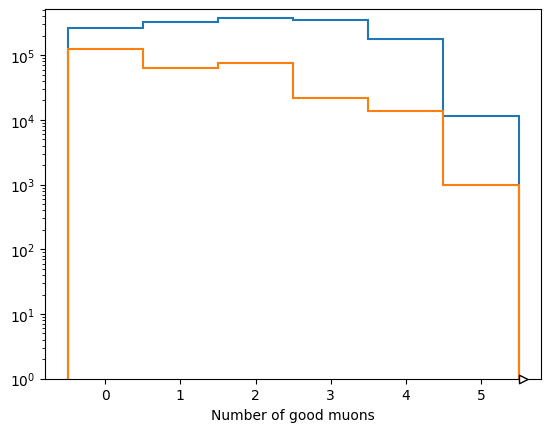

In [25]:
fig, ax = plt.subplots()
scaled["nMuons"].plot1d(ax=ax, overlay="dataset")
ax.set_yscale("log")
ax.set_ylim(1, None)
plt.show()

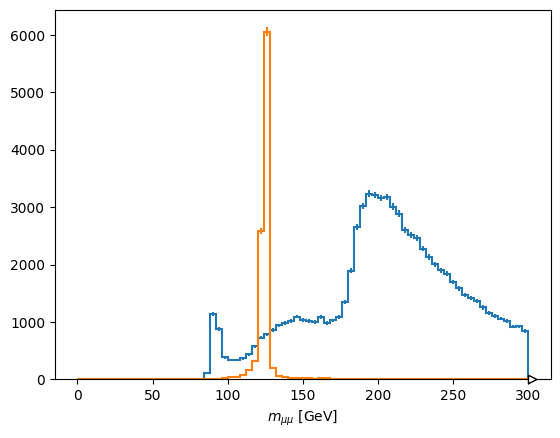

In [26]:
fig, ax = plt.subplots()

scaled["mass"][:, :: hist.rebin(4)].plot1d(ax=ax, overlay="dataset")
plt.show()

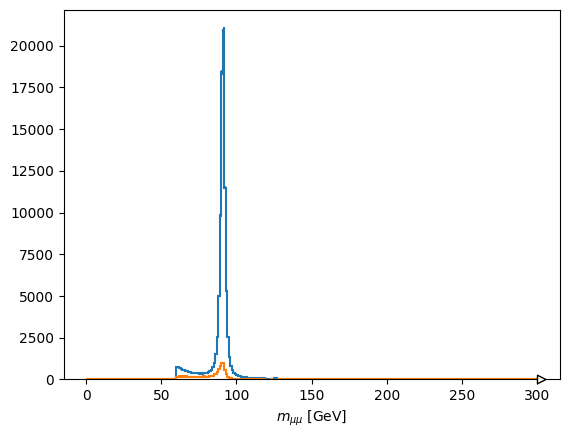

In [27]:
fig, ax = plt.subplots()

scaled["mass_z1"].plot1d(ax=ax, overlay="dataset")
plt.show()

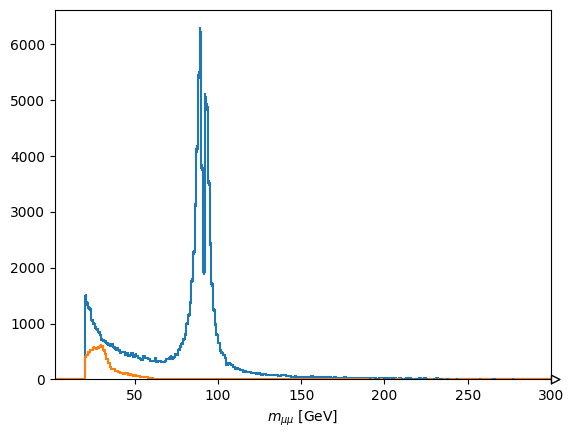

In [28]:
fig, ax = plt.subplots()

scaled["mass_z2"].plot1d(ax=ax, overlay="dataset")
ax.set_xlim(2, 300)
plt.show()

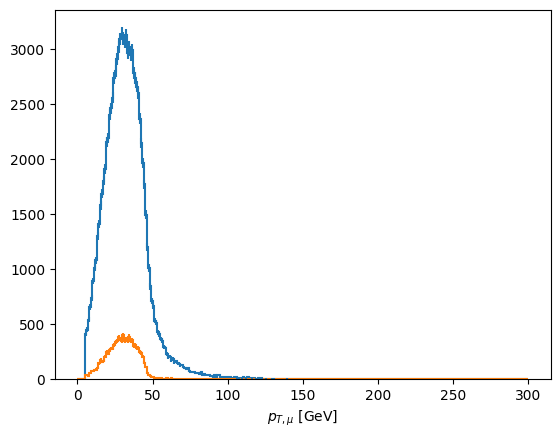

In [29]:
fig, ax = plt.subplots()

scaled["pt_z1_mu1"].plot1d(ax=ax, overlay="dataset")
plt.show()

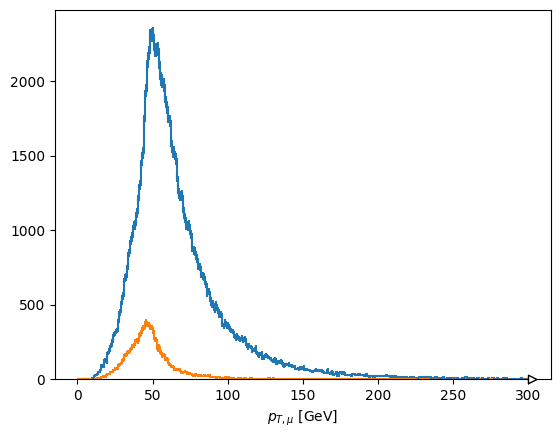

In [30]:
fig, ax = plt.subplots()

scaled["pt_z1_mu2"].plot1d(ax=ax, overlay="dataset");